In [1]:
# -*- coding: utf-8 -*-
"""
created: Sat Mar 21 10:55:27 2020

author: Annette Stellema (astellemas@gmail.com)


"""

import numpy as np
import xarray as xr
from pathlib import Path
from itertools import groupby
from datetime import timedelta
import matplotlib.pyplot as plt
from main import paths, lx
from itertools import groupby


def find_runs(x):
    """Find runs of consecutive items in an array."""

    # ensure array
    x = np.asanyarray(x)
    if x.ndim != 1:
        raise ValueError('only 1D array supported')
    n = x.shape[0]

    # handle empty array
    if n == 0:
        return np.array([]), np.array([]), np.array([])

    else:
        # find run starts
        loc_run_start = np.empty(n, dtype=bool)
        loc_run_start[0] = True
        np.not_equal(x[:-1], x[1:], out=loc_run_start[1:])
        run_starts = np.nonzero(loc_run_start)[0]

        # find run values
        run_values = x[loc_run_start]

        # find run lengths
        run_lengths = np.diff(np.append(run_starts, n))

        return run_values, run_starts, run_lengths


def nino_events(oni):

    dn = xr.full_like(oni, 0)
    dn[oni >= 0.5] = 1
    dn[oni <= -0.5] = 2
    run_values, run_starts, run_lengths = find_runs(dn)
    nino = []
    nina = []
    for i, l in enumerate(run_lengths):
        if l >= 5 and run_values[i] == 1:
            j = run_starts[i]
            nino.append([dn.Time[j].dt.strftime('%Y-%m-%d').item(),
                         dn.Time[j+l-1].dt.strftime('%Y-%m-%d').item()])
        elif l >= 5 and run_values[i] == 2:
            j = run_starts[i]
            nina.append([dn.Time[j].dt.strftime('%Y-%m-%d').item(),
                         dn.Time[j+l-1].dt.strftime('%Y-%m-%d').item()])

    return nino, nina

def plot_oni_valid(ds, da, add_obs_ev=False):
    nino1, nina1 = nino_events(ds.oni)



    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title('Observed and modelled ENSO events', loc='left')

    plt.plot(da.Time, da.oni, color='red', label='NOAA OISST')
    plt.plot(ds.Time, ds.oni, color='k', label='OFAM')

    for y in [0.5, -0.5]:
        plt.hlines(y=y, xmax=ds.Time[-1], xmin=ds.Time[0],
                   linewidth=1, color='blue', linestyle='--')


    for nin, color in zip([nino1, nina1], ['red', 'blue']):
        for x in range(len(nin)):
            ax.axvspan(np.datetime64(nin[x][0]), np.datetime64(nin[x][1]),
                        alpha=0.15, color=color)
    if add_obs_ev:
        nino2, nina2 = nino_events(da.oni)
        for nin, color in zip([nino2, nina2], ['darkred', 'darkblue']):
            for x in range(len(nin)):
                ax.axvspan(np.datetime64(nin[x][0]), np.datetime64(nin[x][1]),
                            alpha=0.1, color=color, hatch='/')

    ax.set_xlim(xmax=ds.Time[-1], xmin=ds.Time[0])
    plt.ylabel('Oceanic Niño Index [°C]')
    plt.legend(fontsize=10, loc=1)
    plt.savefig(fpath/'valid/oni_ofam_noaa.png')

    return


# Path to save figures, save data and OFAM model output.
fpath, dpath, xpath, lpath, tpath = paths()

ds = xr.open_dataset(dpath/'ofam_sst_anom_nino34_hist.nc')
da = xr.open_dataset(dpath/'noaa_sst_anom_nino34.nc')

ds = ds.sel(Time=slice('1981-11-01', '2012-12-01'))
da = da.sel(time=slice('1981-11-01', '2012-12-01')).rename({'time': 'Time'})




In [53]:
files = []
x = 0
exp = lx['years'][x]
for y in range(exp[0], 1991 + 1):
    for m in range(1, 13):
        files.append(str(xpath/('ocean_{}_{}_{:02d}.nc'.format('u', y, m))))
du = xr.open_mfdataset(files, combine='by_coords')

In [ ]:
from main import timer
import time
# plot_oni_valid(ds, da)
lon = 220

# du = du.sel(st_ocean=slice(2.5, 373), xu_ocean=lx['lons']).sel(yu_ocean=0,
#             method='nearest').u
# du = du.resample(Time='MS').mean()

In [74]:
nino, nina = nino_events(da.oni)
enso = xr.DataArray(np.empty((2, *du[0].shape)).fill(np.nan), 
                 coords=[('nin', ['nino', 'nina']), ('st_ocean', du.st_ocean.values), 
                         ('xu_ocean', du.xu_ocean.values)])
t1 = time.time()
for ix, x in enumerate(lx['lons']):
    tx = time.time()
    print(x)
    for nin, dv in zip([nino, nina], [elv, lav]):
        print('nin')
        tn = time.time()
        for iz, z in enumerate(du.st_ocean):
            tmp = []
            tz = time.time()
            for i in range(len(nin)):
                tmp.append(du.sel(Time=slice(nin[i][0], nin[i][1]),
                                    st_ocean=z, xu_ocean=x).values)
            timer(tz, 'z')
            dv[iz, ix] = np.nanmean(tmp)
        timer(tn, 'nin')
    timer(tx, x)
timer(t1)

165
nin


KeyboardInterrupt: 

In [62]:
elv[:,0].values

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan], dtype=float32)

In [55]:
len(du.sel(Time=slice(nin[ix][0], nin[ix][1])).Time)

13

In [64]:
np.nanmean(tmp)

-0.10819699

In [1]:
import sys
import gsw
import numpy as np
import xarray as xr
import matplotlib.colors
from argparse import ArgumentParser
import matplotlib.pyplot as plt
from main import paths, im_ext, idx_1d, lx, width, height, LAT_DEG, SV
from main_valid import EUC_bnds_static, EUC_bnds_grenier, EUC_bnds_izumo


In [8]:
path, dpath, xpath, lpath, tpath = paths()

fileu, files, filet = [], [], []
method='izumo'
exp = 0
for y in range(lx['years'][exp][0], lx['years'][exp][0]+1):
    for m in range(1, 5):
        fileu.append(str(xpath/'ocean_u_{}_{:02d}.nc'.format(y, m)))
        if method != 'static':
            files.append(str(xpath/('ocean_salt_{}_{:02d}.nc'.format(y, m))))
            filet.append(str(xpath/('ocean_temp_{}_{:02d}.nc'.format(y, m))))


du = xr.open_mfdataset(fileu, combine='by_coords')
if method != 'static':
    ds = xr.open_mfdataset(files, combine='by_coords')
    dt = xr.open_mfdataset(filet, combine='by_coords')


dy = LAT_DEG*0.1
dz = [(du.st_ocean[z+1] - du.st_ocean[z]).item()
      for z in range(0, len(du.st_ocean)-1)]

if method == 'static':
    z1, z2, lat = 25, 350, 2.6
    print('{}: 165 started'.format(method))
    dx_165 = EUC_bnds_static(du, lon=165, z1=z1, z2=z2, lat=lat)
    print('{}: 190 started'.format(method))
    dx_190 = EUC_bnds_static(du, lon=190, z1=z1, z2=z2, lat=lat)
    print('{}: 220 started'.format(method))
    dx_220 = EUC_bnds_static(du, lon=220, z1=z1, z2=z2, lat=lat)

elif method == 'izumo':
#     dx_165 = EUC_bnds_izumo(du, dt, ds, lon=165)
#     dx_190 = EUC_bnds_izumo(du, dt, ds, lon=190)
    dx_220 = EUC_bnds_izumo(du, dt, ds, lon=220)

elif method == 'grenier':
#     print('{}: 165 started'.format(method))
#     dx_165 = EUC_bnds_grenier(du, dt, ds, lon=165)
#     print('{}: 190 started'.format(method))
#     dx_190 = EUC_bnds_grenier(du, dt, ds, lon=190)
    print('{}: 220 started'.format(method))
    dx_220 = EUC_bnds_grenier(du, dt, ds, lon=220)


dtx = xr.Dataset()
dtx['uvo'] = xr.DataArray(np.zeros((len(dx_220.Time), 3)),
                          coords=[('Time', dx_220.Time),
                                  ('xu_ocean', lx['lons'])])

dz_i, dz_f = [],  []
for i, lon, dx in zip(range(1), [220], [dx_220]):
    dz_i.append(idx_1d(du.st_ocean, dx.st_ocean[0]))
    dz_f.append(idx_1d(du.st_ocean, dx.st_ocean[-1]))

    dr = (dx*dy).sum(dim='yu_ocean')
    if method != 'grenier':
        dtx.uvo[:, i] = (dr[:, :]*dz[dz_i[i]:dz_f[i]+1]).sum(dim='st_ocean')
    else:
        dtx.uvo[:, i] = (dr[:, :-1]*dz[dz_i[i]:dz_f[i]]).sum(dim='st_ocean')

dtx['uvo'].attrs['long_name'] = ('OFAM3 EUC daily transport {} boundaries'
                                 .format(method))
dtx['uvo'].attrs['units'] = 'm3/sec'

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))


In [7]:
dtx.uvo

<xarray.DataArray 'uvo' (Time: 181, xu_ocean: 3)>
array([[22828183.05105576,        0.        ,        0.        ],
       [22415019.12422353,        0.        ,        0.        ],
       [22109332.7437408 ,        0.        ,        0.        ],
       [22303567.29296303,        0.        ,        0.        ],
       [23359429.24409419,        0.        ,        0.        ],
       [24113742.09049642,        0.        ,        0.        ],
       [24269126.93043362,        0.        ,        0.        ],
       [26069597.49888872,        0.        ,        0.        ],
       [27070694.56607351,        0.        ,        0.        ],
       [28377543.54755393,        0.        ,        0.        ],
       [29748049.04100668,        0.        ,        0.        ],
       [29985734.64046276,        0.        ,        0.        ],
       [28663015.85784817,        0.        ,        0.        ],
       [27712971.39595675,        0.        ,        0.        ],
       [25121762.26986033,        0.        ,        0.        ],
       [23361602.58950305,        0.        ,        0.        ],
       [23888205.25074208,        0.        ,        0.        ],
       [24712742.90557137,        0.        ,        0.        ],
       [25230157.47696227,        0.        ,        0.        ],
       [24573862.89215056,        0.        ,        0.        ],
       [23287668.16935325,        0.        ,        0.        ],
       [22523883.49926978,        0.        ,        0.        ],
       [22570361.64524255,        0.        ,        0.        ],
       [24075299.65558673,        0.        ,        0.        ],
       [24792706.17665184,        0.        ,        0.        ],
       [23328722.54354389,        0.        ,        0.        ],
       [20027512.71349661,        0.        ,        0.        ],
       [20222012.57956837,        0.        ,        0.        ],
       [21768462.65530518,        0.        ,        0.        ],
       [23934125.31948805,        0.        ,        0.        ],
       [26070523.97504905,        0.        ,        0.        ],
       [25583783.82256855,        0.        ,        0.        ],
       [24417930.90082206,        0.        ,        0.        ],
       [25539671.3258419 ,        0.        ,        0.        ],
       [26101628.64251918,        0.        ,        0.        ],
       [24750778.11016184,        0.        ,        0.        ],
       [22914818.92992181,        0.        ,        0.        ],
       [22693754.39248335,        0.        ,        0.        ],
       [24067634.16353284,        0.        ,        0.        ],
       [27387502.90945345,        0.        ,        0.        ],
       [28759040.57394267,        0.        ,        0.        ],
       [30975417.12202985,        0.        ,        0.        ],
       [28357067.8031868 ,        0.        ,        0.        ],
       [27900191.5169244 ,        0.        ,        0.        ],
       [29634747.35788655,        0.        ,        0.        ],
       [30811669.34685704,        0.        ,        0.        ],
       [30509407.77763756,        0.        ,        0.        ],
       [30564523.83577991,        0.        ,        0.        ],
       [32783602.20893285,        0.        ,        0.        ],
       [35849437.53596874,        0.        ,        0.        ],
       [40674601.7308968 ,        0.        ,        0.        ],
       [43134332.93372315,        0.        ,        0.        ],
       [43059233.74746693,        0.        ,        0.        ],
       [42444348.31175915,        0.        ,        0.        ],
       [44662799.51162641,        0.        ,        0.        ],
       [47172672.86655608,        0.        ,        0.        ],
       [48568848.85428938,        0.        ,        0.        ],
       [47988183.68316734,        0.        ,        0.        ],
       [48283659.53119126,        0.        ,        0.        ],
       [49392737.86241731,        0.        ,        0. 

In [9]:
dtx.uvo/1e6

<xarray.DataArray 'uvo' (Time: 120, xu_ocean: 3)>
array([[23.6093513 ,  0.        ,  0.        ],
       [23.06169524,  0.        ,  0.        ],
       [21.36652259,  0.        ,  0.        ],
       [20.77216981,  0.        ,  0.        ],
       [19.50155   ,  0.        ,  0.        ],
       [17.91010825,  0.        ,  0.        ],
       [17.01995514,  0.        ,  0.        ],
       [17.92715962,  0.        ,  0.        ],
       [18.70617756,  0.        ,  0.        ],
       [19.32876663,  0.        ,  0.        ],
       [19.84657703,  0.        ,  0.        ],
       [20.24398174,  0.        ,  0.        ],
       [20.49243435,  0.        ,  0.        ],
       [20.89510684,  0.        ,  0.        ],
       [21.19215953,  0.        ,  0.        ],
       [20.26497325,  0.        ,  0.        ],
       [20.20918347,  0.        ,  0.        ],
       [22.63574918,  0.        ,  0.        ],
       [24.65876816,  0.        ,  0.        ],
       [25.74027388,  0.        ,  0.        ],
       [24.86060291,  0.        ,  0.        ],
       [23.23118891,  0.        ,  0.        ],
       [22.02287084,  0.        ,  0.        ],
       [22.44399786,  0.        ,  0.        ],
       [23.68259938,  0.        ,  0.        ],
       [23.50528926,  0.        ,  0.        ],
       [22.95053949,  0.        ,  0.        ],
       [24.1900785 ,  0.        ,  0.        ],
       [26.47738932,  0.        ,  0.        ],
       [28.0611978 ,  0.        ,  0.        ],
       [26.88331821,  0.        ,  0.        ],
       [23.31875532,  0.        ,  0.        ],
       [19.60581396,  0.        ,  0.        ],
       [20.01595582,  0.        ,  0.        ],
       [21.68436237,  0.        ,  0.        ],
       [22.14074394,  0.        ,  0.        ],
       [20.99170308,  0.        ,  0.        ],
       [19.11289092,  0.        ,  0.        ],
       [19.62712663,  0.        ,  0.        ],
       [19.17836686,  0.        ,  0.        ],
       [19.13632326,  0.        ,  0.        ],
       [20.01211848,  0.        ,  0.        ],
       [20.74659604,  0.        ,  0.        ],
       [22.10113742,  0.        ,  0.        ],
       [25.52382739,  0.        ,  0.        ],
       [26.89454896,  0.        ,  0.        ],
       [27.0417177 ,  0.        ,  0.        ],
       [26.60375673,  0.        ,  0.        ],
       [26.41938497,  0.        ,  0.        ],
       [28.96158254,  0.        ,  0.        ],
       [32.07834688,  0.        ,  0.        ],
       [36.41095104,  0.        ,  0.        ],
       [38.52204031,  0.        ,  0.        ],
       [38.97748406,  0.        ,  0.        ],
       [40.24355284,  0.        ,  0.        ],
       [43.25462332,  0.        ,  0.        ],
       [45.96322207,  0.        ,  0.        ],
       [48.7845269 ,  0.        ,  0.        ],
       [51.75772632,  0.        ,  0.        ],
       [51.84405746,  0.        ,  0.        ],
       [51.96872977,  0.        ,  0.        ],
       [51.43489497,  0.        ,  0.        ],
       [50.94718592,  0.        ,  0.        ],
       [49.85254597,  0.        ,  0.        ],
       [50.59202971,  0.        ,  0.        ],
       [50.34412215,  0.        ,  0.        ],
       [50.21829144,  0.        ,  0.        ],
       [48.32943527,  0.        ,  0.        ],
       [44.4943484 ,  0.        ,  0.        ],
       [43.28248361,  0.        ,  0.        ],
       [42.67235907,  0.        ,  0.        ],
       [42.96500489,  0.        ,  0.        ],
       [44.88279618,  0.        ,  0.        ],
       [46.64090957,  0.        ,  0.        ],
       [45.88606324,  0.        ,  0.        ],
       [45.54421719,  0.        ,  0.        ],
       [46.54638098,  0.        ,  0.        ],
       [47.67869956,  0.        ,  0.        ],
       [47.16439231,  0.        ,  0.        ],
       [46.20185413,  0.        ,  0.        ],
       [44.66828384,  0.        ,  0.        ],
       [43.80358094,  0.        ,  0.        ],
       [43.601

In [93]:
enso = xr.DataArray(np.empty((2, *du[0].shape)).fill(np.nan), 
                 coords=[('nin', ['nino', 'nina']), ('st_ocean', du.st_ocean.values), 
                         ('xu_ocean', du.xu_ocean.values)])

In [22]:
from main import EARTH_RADIUS
from math import radians, cos

MemoryError: Unable to allocate 2.36 TiB for an array with shape (323835494400,) and data type float64

In [35]:
def wind_stress_curl(du, dv, annum=False, EARTH_RADIUS=EARTH_RADIUS, w=1.5):

    # The distance between longitude points [m].
    dx = [(w*((2*np.pi*EARTH_RADIUS)/360)*
           cos(radians(du.lat[i].item()))) for i in range(len(du.lat))]
    # Create array and change shape.
    dx = np.array(dx); dx = dx[:, None]
    DX = dx
    # Create DY meshgrid.
    # Array of the distance between latitude and longitude points [m].
    DY = np.full((len(du.lat), len(du.lon)), w*((2*np.pi*EARTH_RADIUS)/360))

    # Create DX mesh grid.
    for i in range(1, len(du.lon)):
        DX = np.hstack((DX, dx))

    # Calculate the wind stress curl for each month.
    if annum == False:
        phi = np.zeros((12, len(du.lat), len(du.lon)))
        # The distance [m] between longitude grid points.
        for t in range(12):
            du_dx, du_dy = np.gradient(du[t].values)
            dv_dx, dv_dy = np.gradient(dv[t].values)

            phi[t] =  dv_dy/DX - du_dx/DY

        phi_ds = xr.Dataset({'phi': (('time', 'lat', 'lon'),
                                     np.ma.masked_array(phi, np.isnan(phi)))},
                             coords={'time': np.arange(12),
                                     'lat': du.lat, 'lon': du.lon})

#     # Calculate the annual wind stress curl.
#     elif annum == True:
#         du = du.mean('time')
#         dv = dv.mean('time')
#         du_dx, du_dy = np.gradient(du.values)
#         dv_dx, dv_dy = np.gradient(dv.values)
#         phi =  dv_dy/DX - du_dx/DY

#         phi_ds = xr.Dataset({'phi': (('lat', 'lon'),
#                                      np.ma.masked_array(phi, np.isnan(phi)))},
#                              coords={'lat': du.lat, 'lon': du.lon})

    return phi_ds

In [30]:
u = []
v = []
for y in range(1981, 2013):
    u.append('/g/data1/rr7/ERA_INT/ERA_INT/ERA_INT_uas_{}.nc'.format(y))
    v.append('/g/data1/rr7/ERA_INT/ERA_INT/ERA_INT_vas_{}.nc'.format(y))
du = xr.open_mfdataset(u, combine='by_coords')
dv = xr.open_mfdataset(v, combine='by_coords')
du = du.sel(lat=slice(-15, 15), lon=slice(120, 270))
dv = dv.sel(lat=slice(-15, 15), lon=slice(120, 270))
du = du.groupby('time.month').mean()
dv = dv.groupby('time.month').mean()
du = du.interp(lon=np.arange(120, 270.5, 0.5), lon=np.arange(-15, 15.5, 0.5))
dv = dv.interp(lon=np.arange(120, 270.5, 0.5), lon=np.arange(-15, 15.5, 0.5))
phi = wind_stress_curl(du.uas, dv.vas, annum=False, EARTH_RADIUS=EARTH_RADIUS)
phi

<xarray.Dataset>
Dimensions:  (lat: 21, lon: 101, time: 12)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * lat      (lat) float32 -15.0 -13.5 -12.0 -10.5 -9.0 ... 10.5 12.0 13.5 15.0
  * lon      (lon) float32 120.0 121.5 123.0 124.5 ... 265.5 267.0 268.5 270.0
Data variables:
    phi      (time, lat, lon) float64 -1.054e-06 -1.644e-06 ... -4.256e-06

In [47]:
# u = []
# v = []
# for y in range(1981, 2013):
#     u.append('/g/data1/ua8/JRA55-do/latest/u_10.{}.nc'.format(y))
#     v.append('/g/data1/ua8/JRA55-do/latest/v_10.{}.nc'.format(y))
# du = xr.open_mfdataset(u, combine='by_coords')
# dv = xr.open_mfdataset(v, combine='by_coords')

du = xr.open_dataset('/g/data1/ua8/JRA55-do/latest/u_10.1981.nc')
dv = xr.open_dataset('/g/data1/ua8/JRA55-do/latest/v_10.1981.nc')
du = du.rename({'latitude': 'lat', 'longitude': 'lon'})
dv = dv.rename({'latitude': 'lat', 'longitude': 'lon'})
du = du.sel(lat=slice(-15, 15), lon=slice(120, 270))
dv = dv.sel(lat=slice(-15, 15), lon=slice(120, 270))
du = du.groupby('time.month').mean()
dv = dv.groupby('time.month').mean()
du = du.interp(lon=np.arange(120, 270.5, 0.5), lon=np.arange(-15, 15.5, 0.5))
dv = dv.interp(lon=np.arange(120, 270.5, 0.5), lon=np.arange(-15, 15.5, 0.5))

w = 0.5

In [48]:
dv

<xarray.Dataset>
Dimensions:    (lat: 54, lon: 267, time: 2920, time_bnds_dim: 2)
Coordinates:
  * lat        (lat) float64 -14.88 -14.32 -13.76 -13.2 ... 13.76 14.32 14.88
  * lon        (lon) float64 120.4 120.9 121.5 122.1 ... 268.3 268.9 269.4 270.0
  * time       (time) datetime64[ns] 1981-01-01 ... 1981-12-31T21:00:00
Dimensions without coordinates: time_bnds_dim
Data variables:
    time_bnds  (time, time_bnds_dim) datetime64[ns] ...
    vas_10m    (time, lat, lon) float32 ...
Attributes:
    title:        Adjusted Y-ward 10 m wind of JRA55-do
    institution:  JMA Meteorological Research Institute
    comment:      None
    version:      v1.3
    fill_value:   Fill value is -9.99e33

In [49]:
phi = wind_stress_curl(du.uas_10m, dv.vas_10m, annum=False, EARTH_RADIUS=EARTH_RADIUS, w=w)
phi

<xarray.Dataset>
Dimensions:  (lat: 54, lon: 267, time: 12)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * lat      (lat) float64 -14.88 -14.32 -13.76 -13.2 ... 13.2 13.76 14.32 14.88
  * lon      (lon) float64 120.4 120.9 121.5 122.1 ... 268.3 268.9 269.4 270.0
Data variables:
    phi      (time, lat, lon) float64 2.659e-06 3.375e-06 ... -1.748e-06

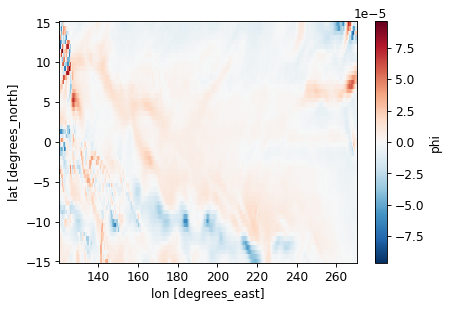

In [52]:
phi.mean('time').phi.plot()

In [55]:
du.interp(lon=np.arange(120, 270.5, 0.5), lon=np.arange(-15, 15.5, 0.5))

array([120. , 120.5, 121. , 121.5, 122. , 122.5, 123. , 123.5, 124. ,
       124.5, 125. , 125.5, 126. , 126.5, 127. , 127.5, 128. , 128.5,
       129. , 129.5, 130. , 130.5, 131. , 131.5, 132. , 132.5, 133. ,
       133.5, 134. , 134.5, 135. , 135.5, 136. , 136.5, 137. , 137.5,
       138. , 138.5, 139. , 139.5, 140. , 140.5, 141. , 141.5, 142. ,
       142.5, 143. , 143.5, 144. , 144.5, 145. , 145.5, 146. , 146.5,
       147. , 147.5, 148. , 148.5, 149. , 149.5, 150. , 150.5, 151. ,
       151.5, 152. , 152.5, 153. , 153.5, 154. , 154.5, 155. , 155.5,
       156. , 156.5, 157. , 157.5, 158. , 158.5, 159. , 159.5, 160. ,
       160.5, 161. , 161.5, 162. , 162.5, 163. , 163.5, 164. , 164.5,
       165. , 165.5, 166. , 166.5, 167. , 167.5, 168. , 168.5, 169. ,
       169.5, 170. , 170.5, 171. , 171.5, 172. , 172.5, 173. , 173.5,
       174. , 174.5, 175. , 175.5, 176. , 176.5, 177. , 177.5, 178. ,
       178.5, 179. , 179.5, 180. , 180.5, 181. , 181.5, 182. , 182.5,
       183. , 183.5,

In [59]:
du['vas_10m'] = dv.vas_10m
du['phi'] = xr.DataArray(phi.phi.values, coords=[('time', du.time), ('lat', du.lat), ('lon', du.lon)])
# du.to_netcdf()

ValueError: conflicting sizes for dimension 'time': length 12 on the data but length 2920 on coordinate 'time'

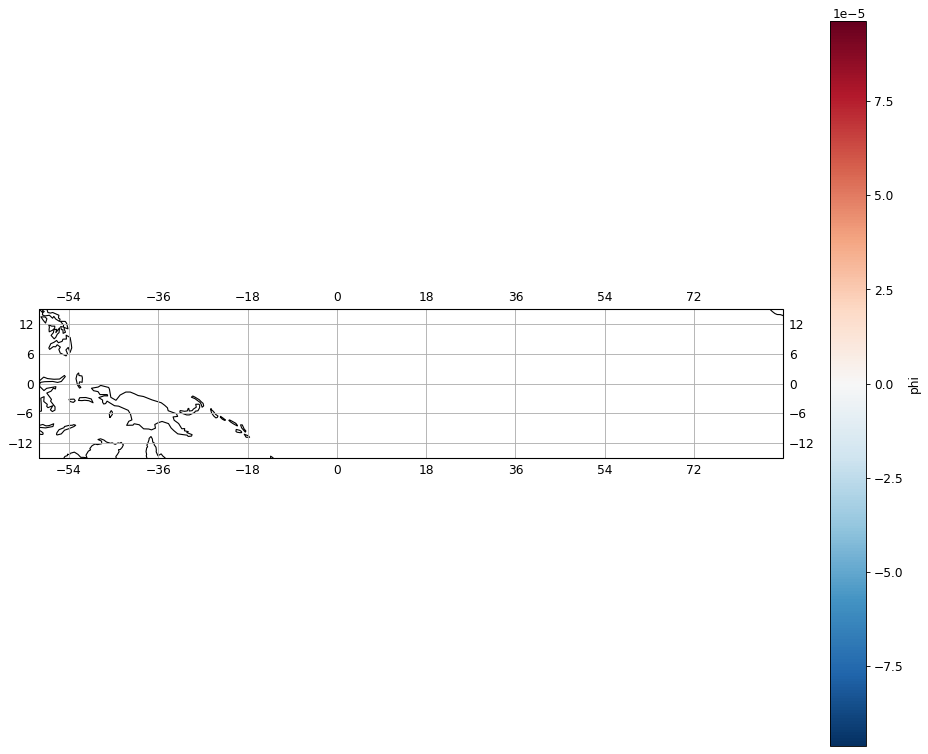

In [94]:

from cartopy import config
import cartopy.crs as ccrs
cm = 180
proj = ccrs.PlateCarree(central_longitude=cm)
# proj = ccrs.LambertCylindrical(central_longitude=180)
fig = plt.figure(figsize=(15, 12))
ax = plt.axes(projection=proj)

ax.set_extent([-60, 90, -15, 15], crs=proj)
# ax.set_xticks(phi.lon, crs=proj)
# ax.set_yticks(phi.lat, crs=proj)
ax.contourf(phi.lon, phi.lat, phi.phi.mean('time'), crs=proj) # , transform=ccrs.proj
ax.coastlines()
ax.gridlines(draw_labels=True, crs=proj)

TypeError: zip argument #2 must support iteration

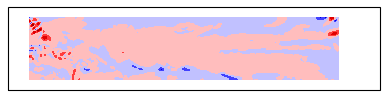

In [113]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import shapely.geometry as sgeom

box = sgeom.box(minx=110, maxx=290, miny=-20, maxy=20)
x0, y0, x1, y1 = box.bounds

proj = ccrs.PlateCarree(central_longitude=180)
box_proj = ccrs.PlateCarree(central_longitude=0)


ax = plt.subplot(111, projection=proj)

ax.set_extent([x0, x1, y0, y1], box_proj)
cs = ax.contourf(phi.lon, phi.lat, phi.phi.mean('time'), transform=box_proj, cmap=plt.cm.seismic)
ax.legend(cs)
plt.title('Zoomed in area')
ax.coastlines()
plt.show()
